The 3 Models are:
- MobileNet
- ShuffleNet
- EfficientNet

# Device Information


In [1]:
! lsblk -io KNAME,TYPE,SIZE,MODEL #disk

KNAME TYPE   SIZE MODEL
sda   disk 388.4M Virtual Disk
sdb   disk    16G Virtual Disk
sdc   disk     1T Virtual Disk


In [2]:
_ = ! apt install lshw #CPU
! lshw

achmadbauravindah           
    description: Computer
    width: 64 bits
    capabilities: smp vsyscall32
  *-core
       description: Motherboard
       physical id: 0
     *-memory
          description: System memory
          physical id: 1
          size: 64GiB
     *-cpu
          product: 12th Gen Intel(R) Core(TM) i9-12900
          vendor: Intel Corp.
          physical id: 2
          bus info: cpu@0
          version: 6.151.2
          width: 64 bits
          capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology tsc_reliable nonstop_tsc cpuid pni pclmulqdq vmx ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap cl

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov  7 14:38:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8             25W /  320W |     762MiB /  10240MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Welcome to Thoracic Abnormalities Detection with Mobile Model


Dataset: Online Dataset
<br>
<br>
Dataset Reference: https://vindr.ai/datasets/cxr

### Connect Google Drive

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import All Requirements Library

In [7]:
# Full Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dropout, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, SeparableConv2D, Add, GlobalAveragePooling2D, Dense, Flatten, AveragePooling2D, Lambda, Rescaling
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import Callback

# MISC
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
# import gdown

In [8]:
# Install Writer Excel (Untuk dokumentasi hasil pelatihan)
_ = ! pip install xlsxwriter

### Set Dataset Path

In [9]:
# Drive
EXCEL_FILENAME = "NIH Thoracic Dataset (Filtered)/Split_NIH_ThoracicAbnotmalities_Dataset.xlsx"

In [ ]:
# # Download Dataset in zip, this happen because more efficient to load npy npy images
# def download_dataset(id_url):
#     # Download Folder from Another Account Shared Folder
#     url = "https://drive.google.com/uc?id=" + id_url
#     # file_output = "Rice Leafs Dataset (Preprocessed).zip"
#     file_output = "NIH Thoracic Dataset (Filtered).zip"
#     gdown.download(url, file_output, quiet=False)

#     # _ = ! unzip "Rice Leafs Dataset (Preprocessed).zip" # unzip if data zipped
#     _ = ! unzip "NIH Thoracic Dataset (Filtered).zip" # unzip if data zipped

# id_url = "1sAwTqnYk92MWnkWvYGJsPetIvfNPH_E-"
# download_dataset(id_url)

Downloading...
From (original): https://drive.google.com/uc?id=1sAwTqnYk92MWnkWvYGJsPetIvfNPH_E-
From (redirected): https://drive.google.com/uc?id=1sAwTqnYk92MWnkWvYGJsPetIvfNPH_E-&confirm=t&uuid=eb2fd9d1-0e73-486d-b623-8172434ee43b
To: /content/NIH Thoracic Dataset (Filtered).zip
100%|██████████| 1.38G/1.38G [00:15<00:00, 91.7MB/s]


### Initiate Labels (Abnormalities)

In [ ]:
meta_data_df = pd.read_excel(EXCEL_FILENAME)
selected_labels = meta_data_df.columns[2:]
selected_labels

Index(['atelectasis', 'cardiomegaly', 'consolidation', 'effusion',
       'infiltration', 'pneumothorax', 'nodule/mass'],
      dtype='object')

### Show 1 Sample Image

Sample Image
Images Path: NIH Thoracic Dataset (Filtered)/Images/00001006_018.png
LABEL: ['infiltration', 'pneumothorax']


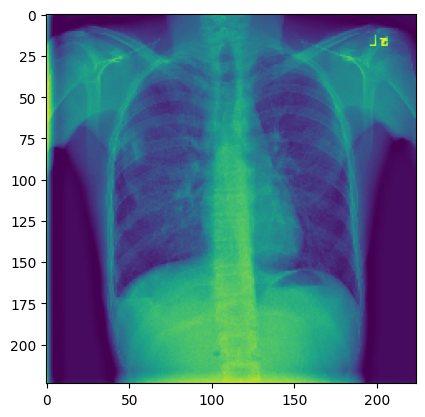

In [ ]:
sample_image = "NIH Thoracic Dataset (Filtered)/Images/" + pd.read_excel(EXCEL_FILENAME)['Image Index'][40]
# Show label
row = meta_data_df.iloc[40, 2:]
labels = row[row == 1].index.tolist()

print("Sample Image")
print("Images Path: {}".format(sample_image))
fig, axes = plt.subplots(1, 1)
_ = axes.imshow(img_to_array(load_img(sample_image, target_size=(224, 224), color_mode='grayscale')).astype('uint8'))
print("LABEL:", labels)

# MobileNet Model


In [ ]:
class MobileNet_Model(Model):
    def __init__(self):
        pass

    def custom_net_layers(self, inputs):
        custom_net_model = tf.keras.applications.MobileNet(
                                                        include_top=False,
                                                        weights=None,
                                                        input_tensor=inputs,
                                                        input_shape=(224, 224, 1),
                                                        pooling='max')
        custom_layers = custom_net_model.output
        return custom_layers



    def call(self, inputs):
        # MobileNet Layers
        custom_net_layers = self.custom_net_layers(inputs)

        # FCL Classifier
        outputs = Dense(3, activation='sigmoid')(custom_net_layers)
        return outputs

def buildModelMobileNet():
    global MobileNet_Model
    # MODEL BUILDING
    input_shape = (224, 224, 1)
    input_layer = Input(shape=input_shape, name='input_layer')
    build_model = MobileNet_Model()
    output_layer = build_model.call(input_layer)

    # Final Model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    learning_rate = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ShuffleNet Models

In [ ]:
# class Xception_Model(Model):
#     def __init__(self):
#         pass

#     def custom_net_layers(self, inputs):
#         custom_net_model = tf.keras.applications.Xception(
#                                                         include_top=False,
#                                                         weights='imagenet',
#                                                         input_tensor=inputs,
#                                                         input_shape=(224, 224, 3),
#                                                         pooling='avg',
#                                                         classes=3)
#         custom_layers = custom_net_model.output
#         return custom_layers



#     def call(self, inputs):
#         # Xception Layers
#         custom_net_layers = self.custom_net_layers(inputs)

#         # FCL Classifier
#         outputs = Dense(3, activation='softmax')(custom_net_layers)
#         return outputs

# def buildModelXception():
#     global Xception_Model
#     # MODEL BUILDING
#     input_shape = (224, 224, 3)
#     input_layer = Input(shape=input_shape, name='input_layer')
#     build_model = Xception_Model()
#     output_layer = build_model.call(input_layer)

#     # Final Model
#     model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
#     learning_rate = 0.001
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#     # Compile Model
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model




# EfficientNet Model


In [ ]:
# class EfficientNetB0_Model(Model):
#     def __init__(self):
#         pass

#     def custom_net_layers(self, inputs):
#         custom_net_model = tf.keras.applications.EfficientNetB0(
#                                                         include_top=False,
#                                                         weights='imagenet',
#                                                         input_tensor=inputs,
#                                                         input_shape=(224, 224, 3),
#                                                         pooling='avg',
#                                                         classes=3)
#         custom_layers = custom_net_model.output
#         return custom_layers



#     def call(self, inputs):
#         # EfficientNetB0 Layers
#         custom_net_layers = self.custom_net_layers(inputs)

#         # FCL Classifier
#         outputs = Dense(3, activation='softmax')(custom_net_layers)
#         return outputs

# def buildModelEfficientNetB0():
#     global EfficientNetB0_Model
#     # MODEL BUILDING
#     input_shape = (224, 224, 3)
#     input_layer = Input(shape=input_shape, name='input_layer')
#     build_model = EfficientNetB0_Model()
#     output_layer = build_model.call(input_layer)

#     # Final Model
#     model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
#     learning_rate = 0.001
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#     # Compile Model
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model




### Get Images Array from Filepath in Excel

In [ ]:
def getArrFromExcel(sheet_name):
    # Get Labels
    meta_data_df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)
    images_path = meta_data_df['Image Index']
    labels = meta_data_df.iloc[:, 2:5]
    # Get Images
    images_arr = []
    i = 0
    for image_path in images_path:
        i+=1
        image_path = "NIH Thoracic Dataset (Filtered)/Images/" + image_path
        # Get Images
        image_arr = img_to_array(load_img(image_path, target_size=(224, 224), color_mode='grayscale'))/255.0
        images_arr.append(image_arr)
        # images_arr.append(np.load(image_path))
        # if i == 500:
        #     break

    return np.array(images_arr), labels

In [ ]:
# # Example
# train_sheet_name_per_fold = "fold_1_val"
# train_images_arr, labels = getArrFromExcel(train_sheet_name_per_fold)
# train_images_arr.shape

### Model Training with K-Fold

# ---MobileNet Training---

In [ ]:
model = buildModelMobileNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,235,463 (12.34 MB)

 Trainable params: 3,213,575 (12.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
drive_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/MobileNet/training/"

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # CALLBACK
    # CSV Logger Callback
    csv_logger_filename = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_filename)

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    model = buildModelMobileNet()

    # Model Training
    history = model.fit(train_images_arr,
                        train_labels,
                        validation_data=(val_images_arr, val_labels),
                        batch_size=32,
                        epochs=100,
                        callbacks=csv_logger_callback)
    # Read CSV Logger After Training
    csv_logger_df = pd.read_csv(csv_logger_filename)
    csv_logger_df.to_csv(csv_logger_filename)

    # Model Per Fold Documentation
    model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))

##################### FOLD - 1 #####################
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.3344 - loss: 0.7590 - val_accuracy: 0.1536 - val_loss: 0.7236
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.4755 - loss: 0.5129 - val_accuracy: 0.1536 - val_loss: 0.7453
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.4767 - loss: 0.5198 - val_accuracy: 0.1536 - val_loss: 0.7631
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4770 - loss: 0.4971 - val_accuracy: 0.1536 - val_loss: 0.7898
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.4765 - loss: 0.5012 - val_accuracy: 0.1536 - val_loss: 0.8141
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4658 - loss: 0.5007 - val_accuracy: 0.1536 - val_loss: 0.8469
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4913 - loss: 0.4831 - val_accuracy: 0.1536 - val_loss: 0.9137
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 97

##################### FOLD - 2 #####################
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.3418 - loss: 0.8148 - val_accuracy: 0.1214 - val_loss: 0.7854
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4598 - loss: 0.5175 - val_accuracy: 0.1214 - val_loss: 0.8787
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.4450 - loss: 0.5208 - val_accuracy: 0.1214 - val_loss: 0.9336
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4592 - loss: 0.5079 - val_accuracy: 0.1214 - val_loss: 0.9752
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4478 - loss: 0.5115 - val_accuracy: 0.1214 - val_loss: 1.0024
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4326 - loss: 0.5078 - val_accuracy: 0.1214 - val_loss: 1.0141
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.4575 - loss: 0.5039 - val_accuracy: 0.1214 - val_loss: 0.9861
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 96m

# ---ShuffleNet Training---

In [ ]:
# model = buildModelShuffleNet()
# model.summary()

In [ ]:
# n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
# n_k_fold = int((n_sheets_excel - 1) / 2)

# # Drive Path
# drive_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/ShuffleNet/training/"

# for k in range(1, n_k_fold + 1):
#     print("##################### FOLD - {} #####################".format(k))

#     # CALLBACK
#     # CSV Logger Callback
#     csv_logger_filename = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
#     csv_logger_callback = CSVLogger(csv_logger_filename)

#     # Sheet Name
#     train_sheet_name_per_fold = "fold_{}_train".format(k)
#     val_sheet_name_per_fold = "fold_{}_val".format(k)
#     # Get Array Images and Masks
#     train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
#     val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

#     # Build Model
#     model = buildModelEfficientNetB0()

#     # Model Training
#     history = model.fit(train_images_arr,
#                         train_labels,
#                         validation_data=(val_images_arr, val_labels),
#                         batch_size=32,
#                         epochs=100,
#                         callbacks=csv_logger_callback)
#     # Read CSV Logger After Training
#     csv_logger_df = pd.read_csv(csv_logger_filename)
#     csv_logger_df.to_csv(csv_logger_filename)

#     # Model Per Fold Documentation
#     model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))

# ---EfficientNetB0 Training---

In [ ]:
# model = buildModelEfficientNetB0()
# model.summary()

In [ ]:
# n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
# n_k_fold = int((n_sheets_excel - 1) / 2)

# # Drive Path
# drive_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/EfficientNetB0/training/"

# for k in range(1, n_k_fold + 1):
#     print("##################### FOLD - {} #####################".format(k))

#     # CALLBACK
#     # CSV Logger Callback
#     csv_logger_filename = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
#     csv_logger_callback = CSVLogger(csv_logger_filename)

#     # Sheet Name
#     train_sheet_name_per_fold = "fold_{}_train".format(k)
#     val_sheet_name_per_fold = "fold_{}_val".format(k)
#     # Get Array Images and Masks
#     train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
#     val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

#     # Build Model
#     model = buildModelEfficientNetB0()

#     # Model Training
#     history = model.fit(train_images_arr,
#                         train_labels,
#                         validation_data=(val_images_arr, val_labels),
#                         batch_size=32,
#                         epochs=100,
#                         callbacks=csv_logger_callback)
#     # Read CSV Logger After Training
#     csv_logger_df = pd.read_csv(csv_logger_filename)
#     csv_logger_df.to_csv(csv_logger_filename)

#     # Model Per Fold Documentation
#     model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))